# Pytorch Example

This notebook walks through essentially **all** the major steps of the submission process. The only step you have to do is create and zip up the files (main.py, agent.py, and any models or other files you need) and submit them to our website.

Specifically, this notebook will...

- Load train.csv into a pandas dataframe
- Train a RL agent using our custom gym environment* 
- Save model to disk 
- Show how to write an agent.py file to use model (see sample agent.py for details)
- Show how to write a main.py file to take row as stdin and output (Action, frac) as stdout

This notebook does not complete the final steps, namely...

- Actually create agent.py 
- Actually create main.py
- Zip agent.py, main.py, and any model files together and submit on \<insert website url\>
- Note your score and try again!

*See util.py or the deep_stock_trader_custom_environment notebook for more details

---

The model trained here is super basic (and the code has a nasty buy somewhere causing it to only HOLD when evaluated...). Attend Josiah's RL course to learn more. You can also start playing with the network's architecture and the training hyperparameters. Maybe adjust the reward function in the DeepStockTraderEnv. Are there ways to include context/memory? So much to explore!

***PLEASE SEE THE END OF THIS NOTEBOOK WHICH OUTLINES HOW TO SUBMIT TO OUR WEBSITE!!***

---

Good luck, <br>
Seth Hamilton | TAMU Datathon R&D

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from util import Action, DeepStockTraderEnv
from collections import namedtuple  
import math
import random
import matplotlib.pyplot as plt
from IPython import display

## Define the network

In [ ]:
class TraderNetwork(nn.Module):
    def __init__(self, row_size):
        super(TraderNetwork, self).__init__()

        self.size = row_size

        self.fc1 = nn.Linear(row_size, row_size*2)
        self.fc2 = nn.Linear(row_size*2, row_size)
        self.fc3 = nn.Linear(row_size, 3)

    def forward(self, t):
        # Have the tensor "flow" through the network
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = F.relu(self.fc3(t))

        return t

## Define helper classes

Much of the following code was copied from DeepLizard.com's RL pytorch course. I highly recommend it. 

Check it out here: [RL pytorch course](https://deeplizard.com/learn/playlist/PLZbbT5o_s2xoWNVdDudn51XM8lOuZ_Njv)

In [ ]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

In [ ]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions)

    @staticmethod        
    def get_next(target_net, next_states):  
        return target_net(next_states).max(dim=1)[0]

In [ ]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [ ]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [ ]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

In [ ]:
class TrainingAgent:
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            return random.randrange(self.num_actions) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=0).item() # exploit    


## Environment/Data setup

In [ ]:
df = pd.read_csv("mystery_stock_daily_train.csv")
env = DeepStockTraderEnv(df)

## Hyperparameters and Training Loop

In [ ]:
# Hyperparameters (Feel free to tune)
batch_size = 8
gamma = 0.9
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
n_episodes = 1000

In [ ]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

def plot(values, moving_avg_period):
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Total Money USD')
    plt.plot(values)
    plt.plot(get_moving_average(moving_avg_period, values))
    plt.show()

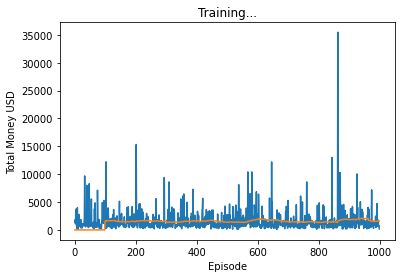

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Using a target size (torch.Size([8, 1, 8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


In [ ]:
# Other important setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
t_agent = TrainingAgent(strategy, env.action_space.n, device)
memory = ReplayMemory(memory_size)

policy_net = TraderNetwork(env.row_size).to(device, dtype=torch.double)
target_net = TraderNetwork(env.row_size).to(device, dtype=torch.double)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_values = []
max_value = 0

# TRAINING LOOP
for episode in range(n_episodes):
    state = env.reset()
    state = torch.tensor(state, dtype=torch.double, device=device)

    display.clear_output(wait=True)
    plot(episode_values, 100)
    
    timestep = 0
    while True:
        action = t_agent.select_action(state, policy_net)

        next_state, reward, done, info = env.step(Action(action))
        next_state = torch.tensor(next_state, dtype=torch.double, device=device)

        action_t = torch.tensor([action]).unsqueeze(0)
        reward_t = torch.tensor([reward]).unsqueeze(0)

        memory.push(Experience(state.unsqueeze(0), action_t, next_state.unsqueeze(0), reward_t))
        state = next_state

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            total = env.total(timestep=-1, open=False)
            episode_values.append(total)
            if total > max_value:
                max_value = total
                torch.save(policy_net.state_dict(), "./example_model.pt")
            break

        timestep += 1

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

## Sample Submission Construction

Remember: You need to submit a zip file containing
- main.py
- agent.py
- example_model.pt (or the name of your model file)

### Example agent.py

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
from enum import IntEnum

class Action(IntEnum):
    BUY = 0
    SELL = 1
    HOLD = 2

# You need to include any network definitions
class TraderNetwork(nn.Module):
    def __init__(self, row_size):
        super(TraderNetwork, self).__init__()

        self.size = row_size

        self.fc1 = nn.Linear(row_size, row_size*2)
        self.fc2 = nn.Linear(row_size*2, row_size)
        self.fc3 = nn.Linear(row_size, 3)

    def forward(self, t):
        # Have the tensor "flow" through the network
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = F.relu(self.fc3(t))

        return t

class Agent:
    def __init__(self, row_size):
        """
        Write your custom initialization sequence here.
        This can include loading models from file.
        """
        self.tn = TraderNetwork(row_size).double()        
        self.tn.load_state_dict(torch.load("./example_model.pt"))        
        self.tn.eval()

    def step(self, row):
        """
        Make a decision to be executed @ the open of the next timestep. 

        row is a numpy array with the same format as the training data

        Return a tuple (Action, fraction). Fraction means different 
        things for different actions...
        
        Action.BUY:  represents fraction of cash to spend on purchase 
        Action.SELL: represents fraction of owned shares to sell 
        Action.HOLD: value ignored.

        See the code below on how to return
        """

        t = torch.tensor(row)
        choice = torch.argmax(self.tn(t).squeeze(0)).item()

        # The plan was to never have to use constants...
        # Yeah, we're assuming consistency in buy=0, sell=1, and hold=2
        if choice == 0:
            return (Action.BUY, 1)
        elif choice == 1:
            return (Action.SELL, 1)

        return (Action.HOLD, 0)

### Example main.py

I call this an "example", but literally this is what your main.py file should contain. (You might need to slightly change if if you mess with your agent's constructor or step function interface)

In [ ]:
import sys
from agent import Agent

a = None
for line in sys.stdin:
    row = line.split(',')
    row = np.array([float(x.strip()) for x in row])
    if not a:
        a = Agent(len(row))

    res = a.step(row)
    print(f"{res[0].name} {res[1]}")


## Evaluate your model

In [ ]:
from util import Evaluation

agent = Agent(env.row_size)
e = Evaluation(df, 1000, agent)

print("---------------Evaluation Stats---------------")
print(f"total:    {e.total()}")
print(f"cash:     {e.cash}")
print(f"n_shares: {e.n_shares}")
print(f"n_buys:   {e.n_buys}")
print(f"n_sells:  {e.n_sells}")
print(f"n_holds:  {e.n_holds}")

plt.plot(e.account_values)
plt.title("Account Value over Time")
plt.xlabel("Days")
plt.ylabel("Money (USD)")